In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [39]:
# Function to load and preprocess data from CSV files
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    df.dropna(inplace=True)
    
    # Splitting columns
    df = df['Time (s), X (m/s2), Y (m/s2), Z (m/s2), R (m/s2), Theta (deg), Phi (deg)'].str.split(',', expand=True)
    df.columns = ['Time', 'X', 'Y', 'Z', 'R', 'Theta', 'Phi']
    
    # Converting data types
    df = df.astype(float)
    print(df)
    # Normalizing data
    scaler = StandardScaler()
    df[['X', 'Y', 'Z', 'R', 'Theta', 'Phi']] = scaler.fit_transform(df[['X', 'Y', 'Z', 'R', 'Theta', 'Phi']])
    
    return df


In [40]:
# Load data from CSV files
files = ['/kaggle/input/gait-dataset/Final_Dataset/Abhay/LA.csv', '/kaggle/input/gait-dataset/Final_Dataset/Abhay/LH.csv', '/kaggle/input/gait-dataset/Final_Dataset/Abhay/LK.csv', '/kaggle/input/gait-dataset/Final_Dataset/Abhay/RA.csv', '/kaggle/input/gait-dataset/Final_Dataset/Abhay/RH.csv', '/kaggle/input/gait-dataset/Final_Dataset/Abhay/RK.csv']
data = [load_and_preprocess(file) for file in files]


            Time         X         Y         Z         R      Theta        Phi
0       0.000000 -1.619343  9.736994 -0.554537  9.886295  93.215492  99.442345
1       0.002349 -1.518844  9.669994 -0.592822  9.806483  93.465759  98.926392
2       0.004698 -1.456631  9.540782 -0.597607  9.669820  93.543213  98.680550
3       0.007047 -1.389632  9.425926 -0.578465  9.545354  93.474350  98.386505
4       0.009396 -1.423131  9.325428 -0.559322  9.449961  93.393196  98.676826
...          ...       ...       ...       ...       ...        ...        ...
12046  28.298882 -0.891925  9.559925 -1.085743  9.662636  96.451675  95.330170
12047  28.301231 -0.958924  9.526425 -1.191028  9.648360  97.090881  95.747993
12048  28.303581 -1.030708  9.502497 -1.224527  9.636352  97.300529  96.190506
12049  28.305929 -1.073779  9.526425 -1.219741  9.664034  97.250900  96.431000
12050  28.308279 -1.068994  9.497711 -1.191028  9.631605  97.103279  96.421768

[12051 rows x 7 columns]
            Time         X

In [43]:
# Transform time series to supervised learning structure
def create_dataset(dataset, time_steps=25, output_steps=5):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - output_steps):
        dataX.append(dataset[i:(i + time_steps)].iloc[:, 1:].values)
        dataY.append(dataset[(i + time_steps):(i + time_steps + output_steps)].iloc[:, 1:].values)
        print(dataX)
        print(1)
        print(dataY)
    return np.array(dataX), np.array(dataY)

time_steps = 25
output_steps = 5


In [ ]:
# Assuming each CSV file has the same structure and length
X, y = [], []
for i in range(len(data)):
    dataset = data[i]
    dataX, dataY = create_dataset(dataset, time_steps, output_steps)
#     print(dataX)
#     print(1)
#     print(dataY)
    print(dataX.shape)
    print(dataY.shape)
    X.append(dataX)
    y.append(dataY)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
print(X)
print(1)
print(y)


In [25]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(output_steps * X.shape[2]))
model.compile(optimizer=SGD(learning_rate=0.07, momentum=0.9, clipnorm=1.0), loss='mae')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Reshape output data
y_train = y_train.reshape((y_train.shape[0], output_steps * X_train.shape[2]))
y_val = y_val.reshape((y_val.shape[0], output_steps * X_val.shape[2]))

# Train the model with validation
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2532 - val_loss: 0.1493
Epoch 2/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1337 - val_loss: 0.1281
Epoch 3/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1212 - val_loss: 0.1250
Epoch 4/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1197 - val_loss: 0.1178
Epoch 5/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1148 - val_loss: 0.1182
Epoch 6/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1119 - val_loss: 0.1174
Epoch 7/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1078 - val_loss: 0.1154
Epoch 8/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1054 - val_loss: 0.1148
Epoch 9/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1066 - val_loss: 0.1120
Epoch 10/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1027 - val_loss: 0.1135
Epoch 11/50
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1007 - val_loss: 0.1103
Epoch 12/50
1286/1286 ━━━━━━━━

In [28]:
# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f'Model Loss: {loss}')


322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0950
Model Loss: 0.09236989915370941


In [29]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Reshape predictions and actual values for comparison
y_pred = y_pred.reshape((y_pred.shape[0], output_steps, X_val.shape[2]))
y_val = y_val.reshape((y_val.shape[0], output_steps, X_val.shape[2]))

# Print and compare predictions with actual outputs
for i in range(len(files)):
    print(f'Joint: {files[i]}')
    print('Predictions:')
    print(y_pred[:5, :, :])  # Printing first 5 predictions for brevity
    print('Actual:')
    print(y_val[:5, :, :])  # Printing first 5 actual outputs for brevity
    print()

322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Joint: /kaggle/input/gait-dataset/Final_Dataset/Abhay/LA.csv
Predictions:
[[[-0.08151633 -0.04175103 -0.35888657 -0.09316278  0.41227257
    0.09303118]
  [-0.07843959 -0.04166479 -0.3696646  -0.09535396  0.42039266
    0.08950219]
  [-0.07712531 -0.04491612 -0.36335793 -0.09742653  0.41559938
    0.0839677 ]
  [-0.07657612 -0.05273888 -0.35396385 -0.10198599  0.4025996
    0.08420306]
  [-0.0771322  -0.05768264 -0.34216824 -0.1018883   0.3950324
    0.08194779]]

 [[-1.5043453  -0.36310282  0.7767438  -0.07987452 -0.9123152
    1.6616682 ]
  [-1.4969108  -0.36270893  0.76237565 -0.08132446 -0.8898273
    1.6539868 ]
  [-1.4935237  -0.36752653  0.75869656 -0.08986956 -0.8730904
    1.6544003 ]
  [-1.4924685  -0.39470136  0.74241257 -0.1107704  -0.8602313
    1.6535028 ]
  [-1.4920697  -0.41936472  0.70984685 -0.1274072  -0.8313593
    1.6545388 ]]

 [[-0.52494425  0.09898572  0.9335433   0.26245558 -0.92403036
    0.5136299 ]
  [-0.5200789   0.0

In [30]:
# Calculate and print error metrics
for i in range(X_val.shape[2]):
    mae = mean_absolute_error(y_val[:, :, i].flatten(), y_pred[:, :, i].flatten())
    mse = mean_squared_error(y_val[:, :, i].flatten(), y_pred[:, :, i].flatten())
    print(f'Joint {i+1}: MAE = {mae}, MSE = {mse}')


Joint 1: MAE = 0.06952363884905562, MSE = 0.11164369919029246
Joint 2: MAE = 0.08600263123905641, MSE = 0.1414859478446253
Joint 3: MAE = 0.12272915505612603, MSE = 0.1429841658149237
Joint 4: MAE = 0.08599988839339599, MSE = 0.1724614271528404
Joint 5: MAE = 0.12235901489462928, MSE = 0.08085380222186211
Joint 6: MAE = 0.06760522375665708, MSE = 0.10580299740926648


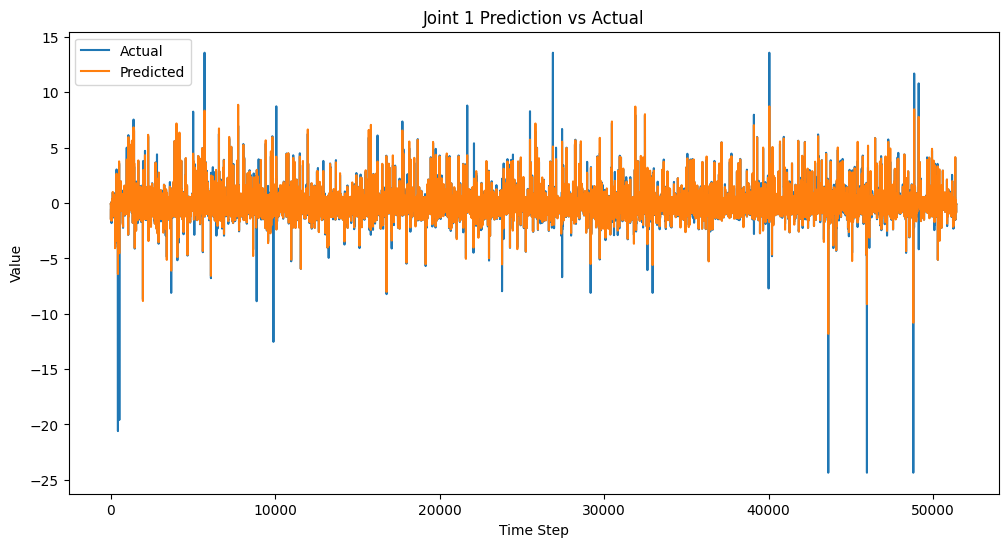

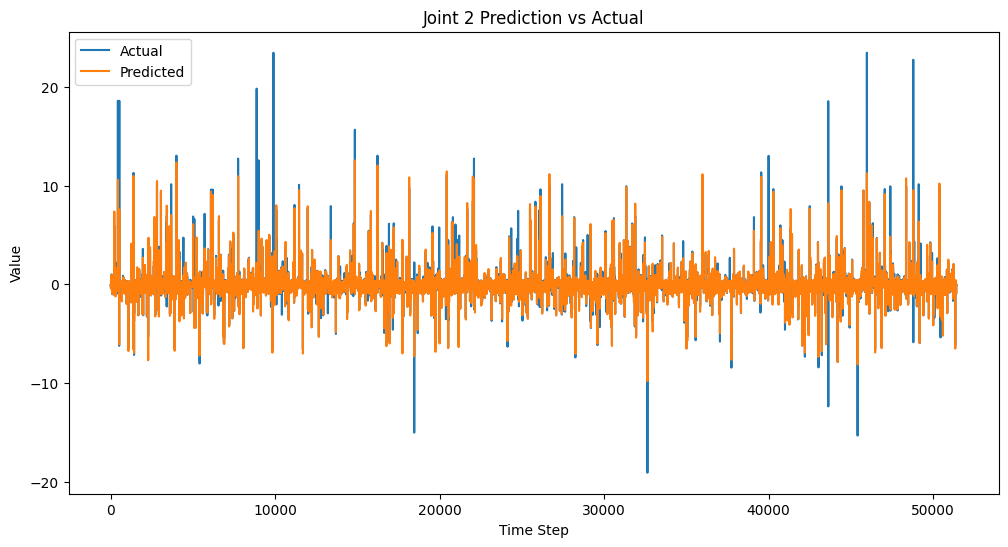

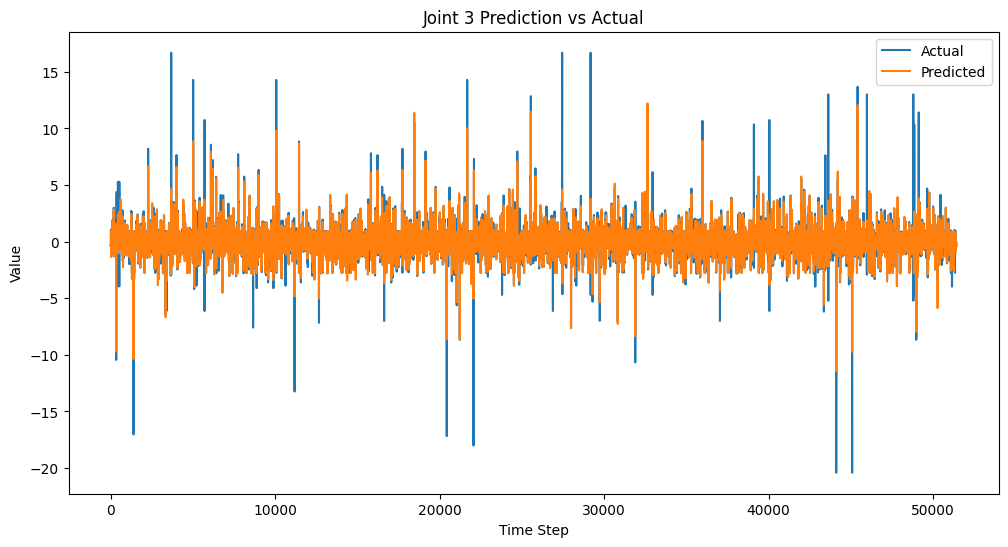

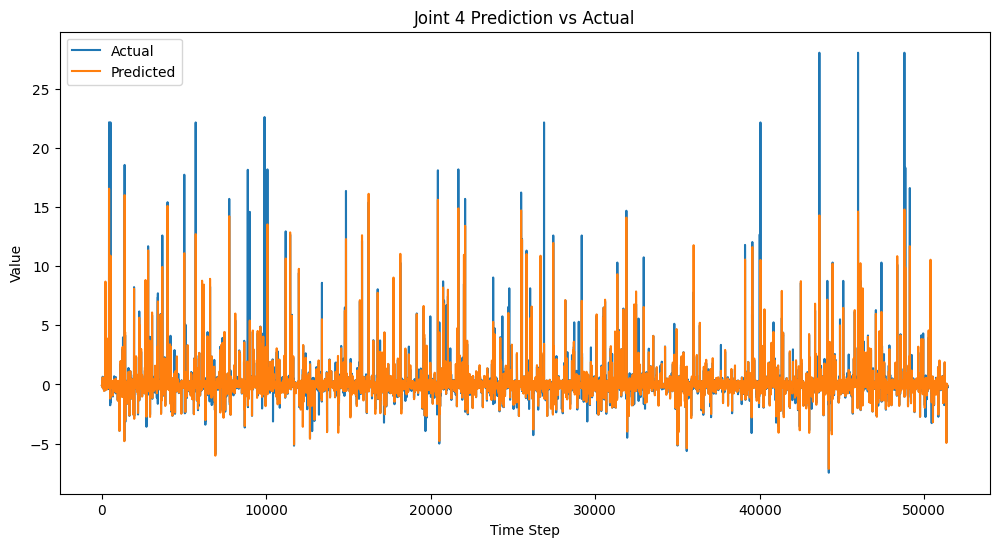

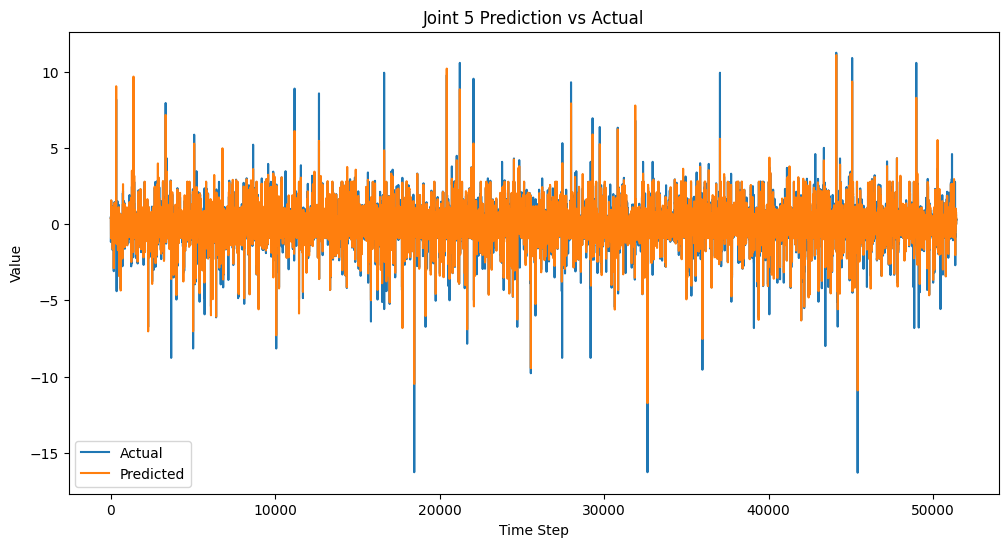

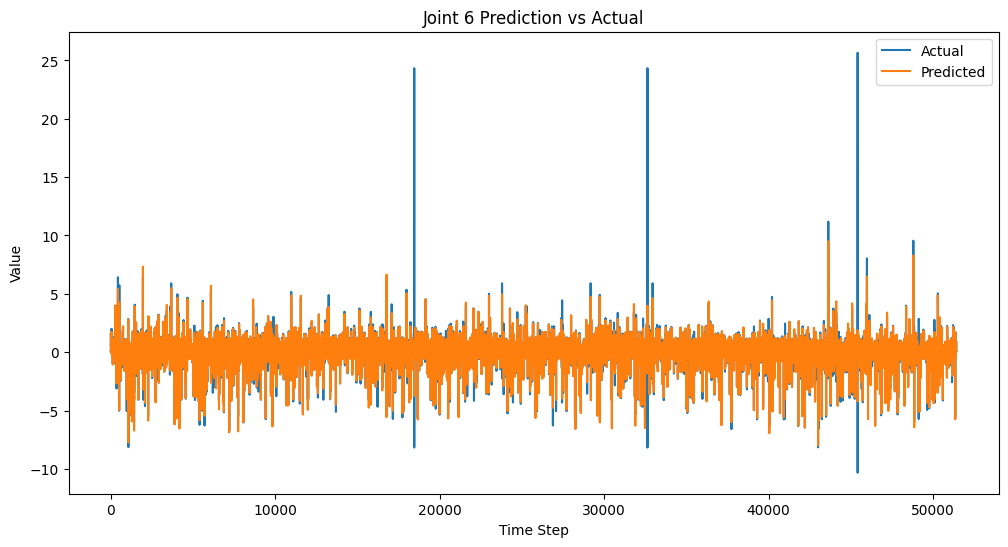

In [31]:
# Plot predictions vs actual values for a visual comparison
for i in range(X_val.shape[2]):
    plt.figure(figsize=(12, 6))
    plt.plot(y_val[:, :, i].flatten(), label='Actual')
    plt.plot(y_pred[:, :, i].flatten(), label='Predicted')
    plt.title(f'Joint {i+1} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

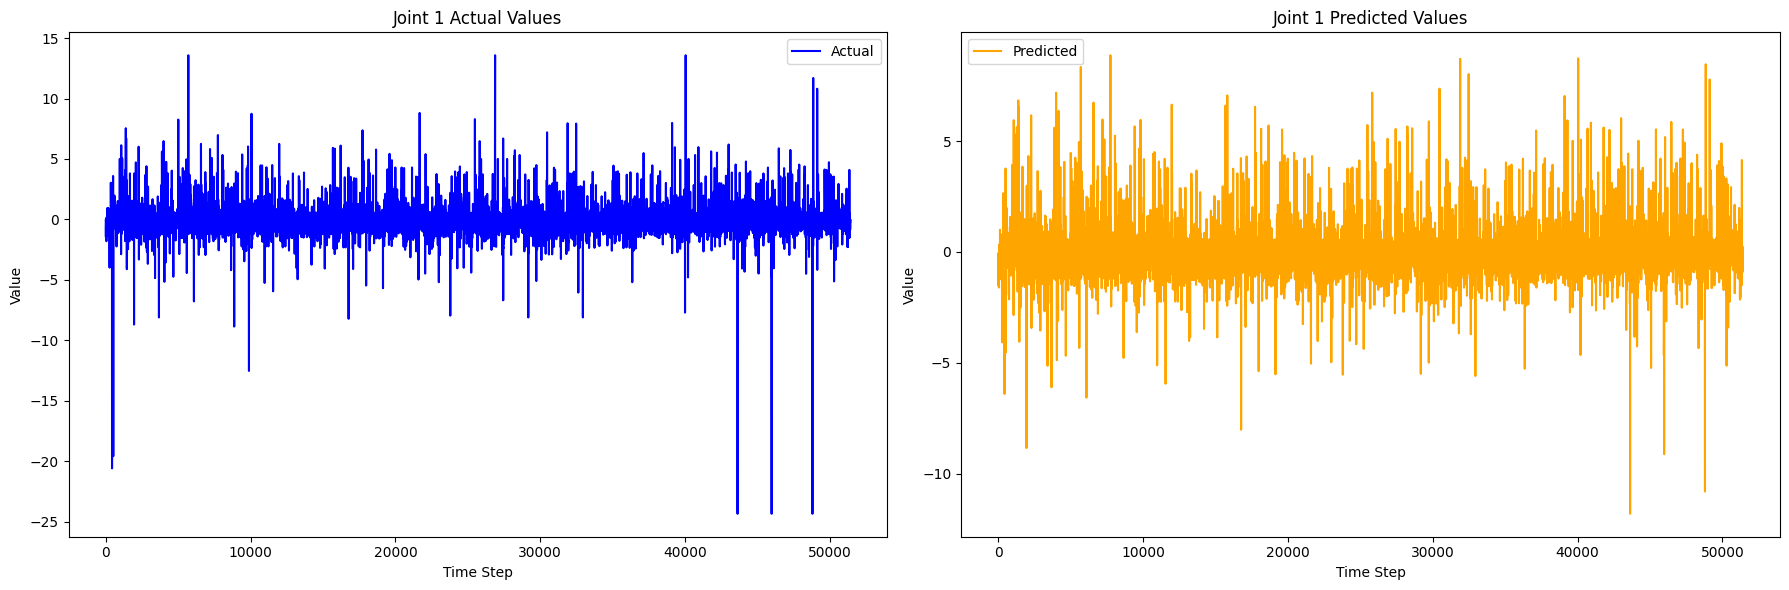

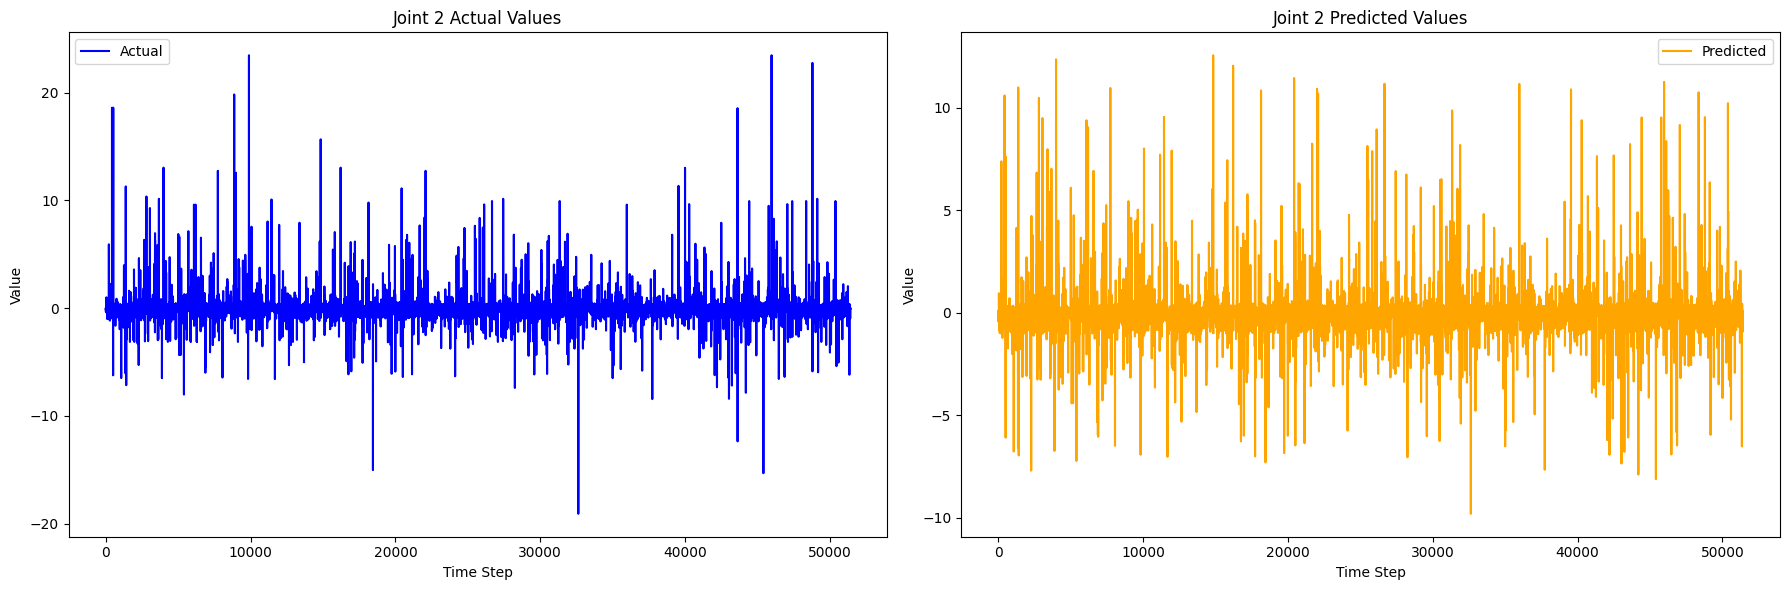

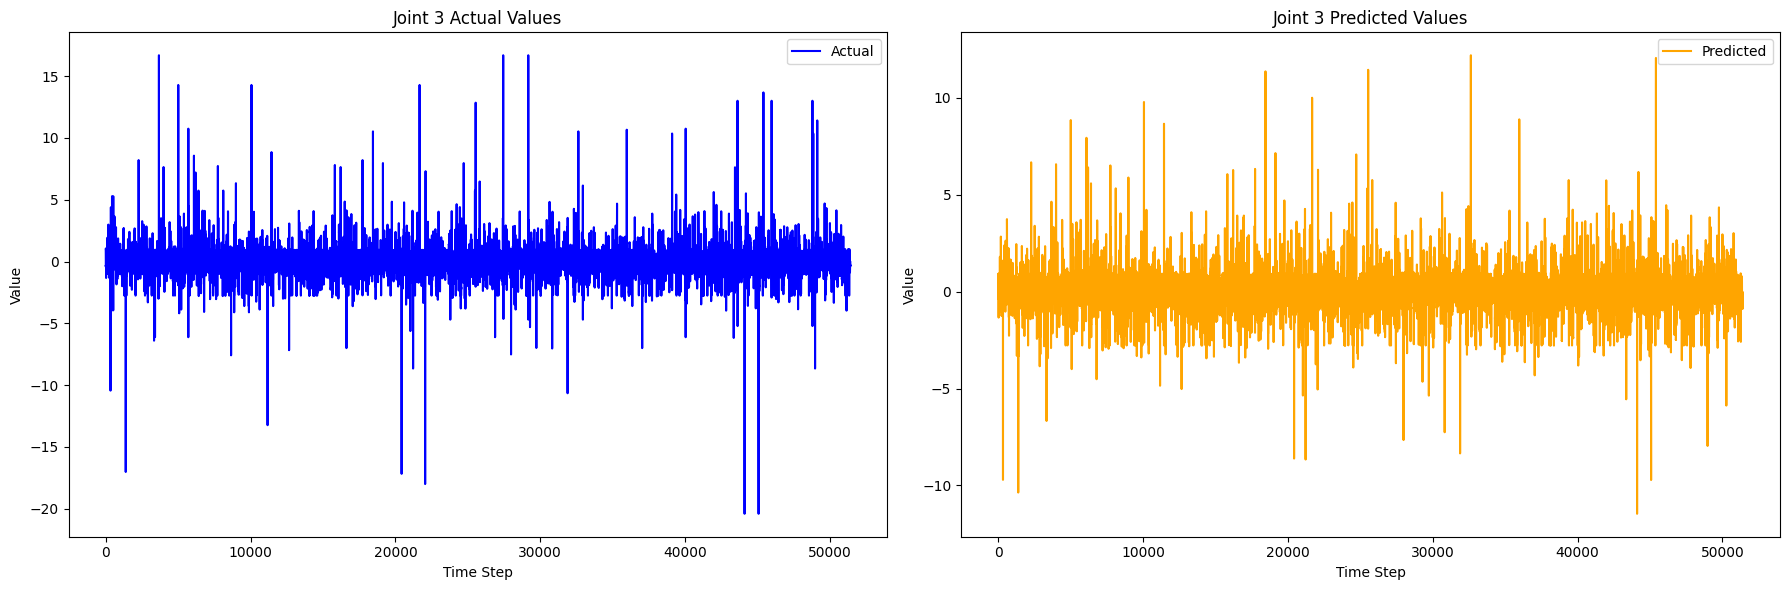

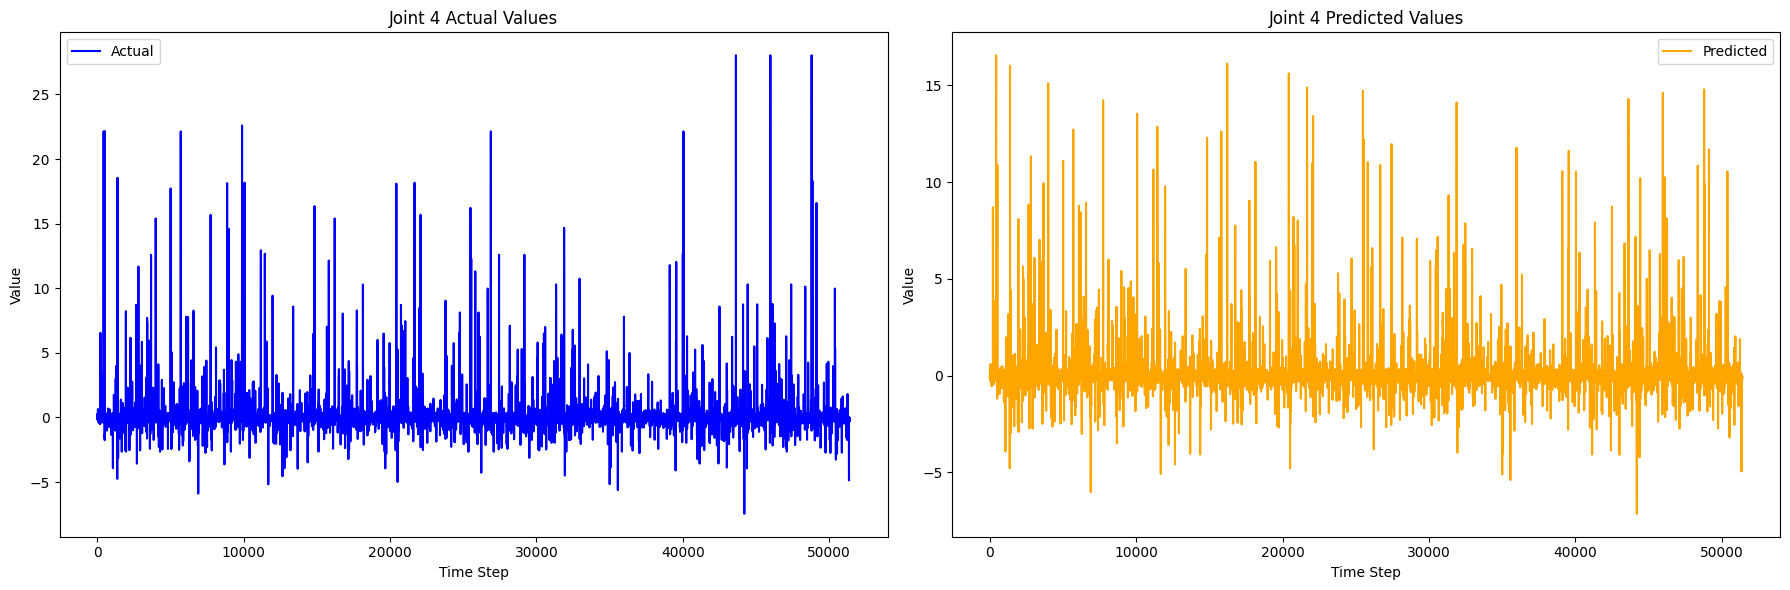

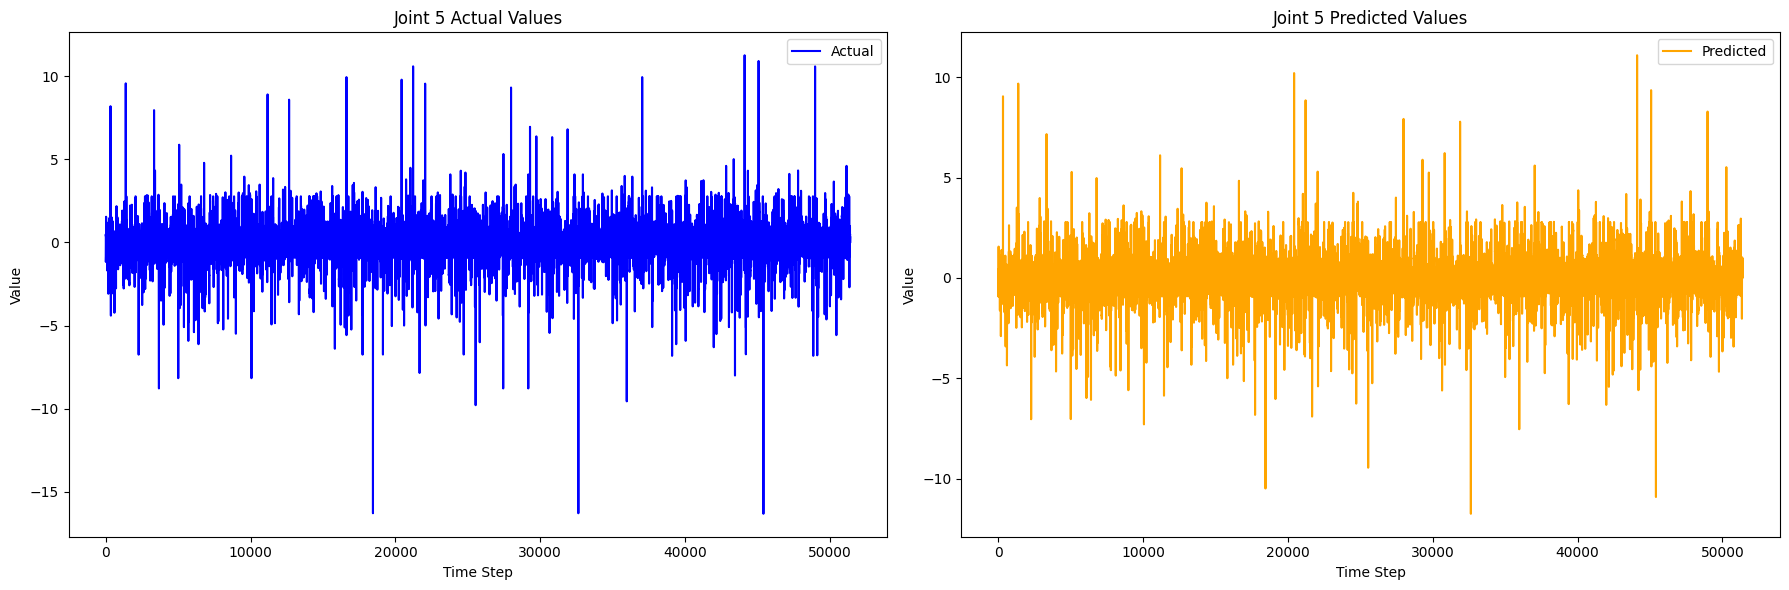

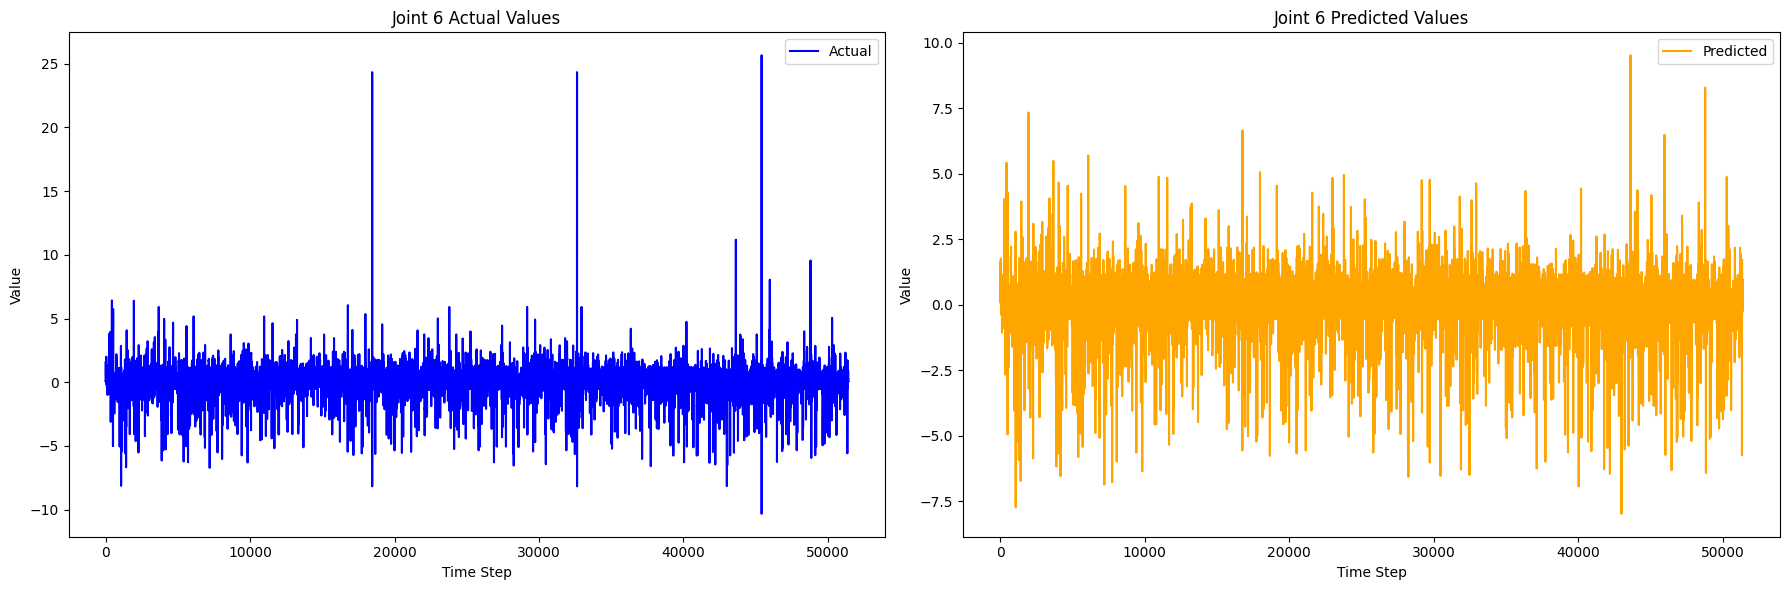

In [32]:
# Plot predictions vs actual values for a visual comparison side by side
for i in range(X_val.shape[2]):
    plt.figure(figsize=(18, 6))
    
    # Plot actual values
    plt.subplot(1, 2, 1)
    plt.plot(y_val[:, :, i].flatten(), label='Actual', color='blue')
    plt.title(f'Joint {i+1} Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot predicted values
    plt.subplot(1, 2, 2)
    plt.plot(y_pred[:, :, i].flatten(), label='Predicted', color='orange')
    plt.title(f'Joint {i+1} Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



Comparison for LA - X
   Actual X  Predicted X
0 -0.087028    -0.081516
1 -1.449044    -1.504345
2 -0.546997    -0.524944
3 -0.076019    -0.087650
4 -0.051702    -0.053562
5 -0.144093    -0.123103
6 -0.619039    -0.603233
7 -0.081593    -0.097175
8 -1.611285    -1.567121
9 -1.501323    -1.473620


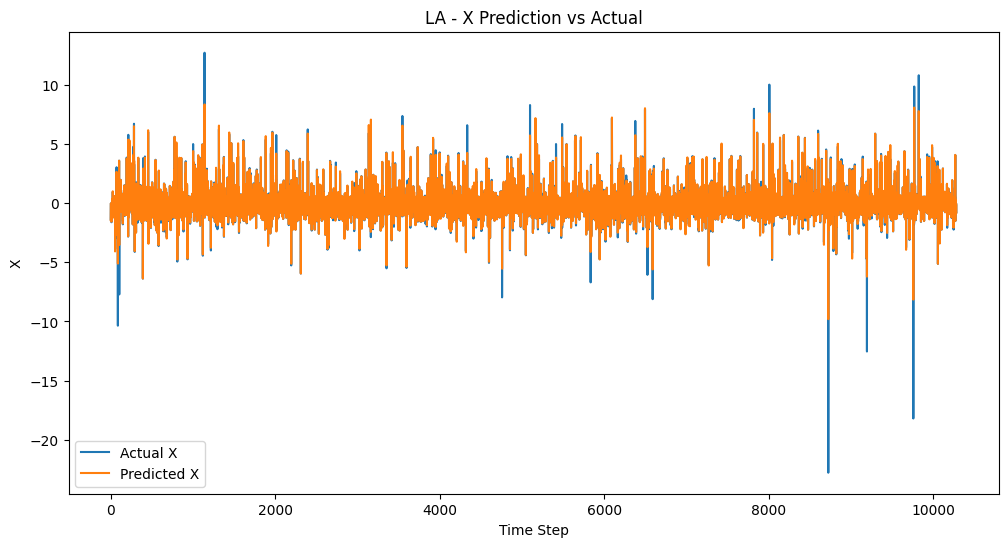


Comparison for LA - Y
   Actual Y  Predicted Y
0 -0.108767    -0.078440
1 -1.452970    -1.496911
2 -0.545637    -0.520079
3 -0.085011    -0.079246
4 -0.048984    -0.051353
5 -0.141376    -0.133521
6 -0.624476    -0.597080
7 -0.130506    -0.106469
8 -1.661247    -1.583143
9 -1.456843    -1.398491


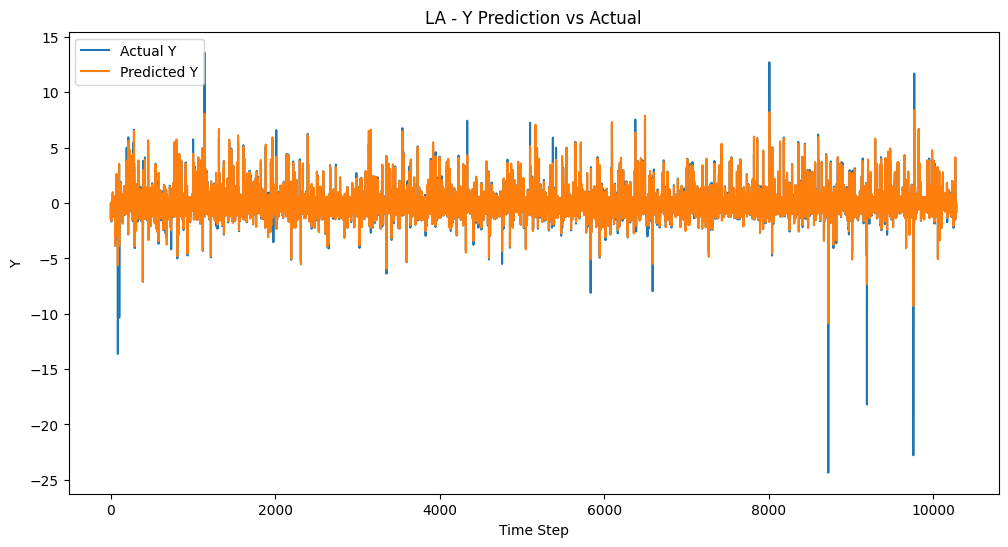


Comparison for LA - Z
   Actual Z  Predicted Z
0 -0.087028    -0.077125
1 -1.453026    -1.493524
2 -0.544278    -0.518881
3 -0.077276    -0.074199
4 -0.038115    -0.054080
5 -0.154963    -0.146657
6 -0.623116    -0.594130
7 -0.144093    -0.114834
8 -1.721798    -1.600304
9 -1.402693    -1.319898


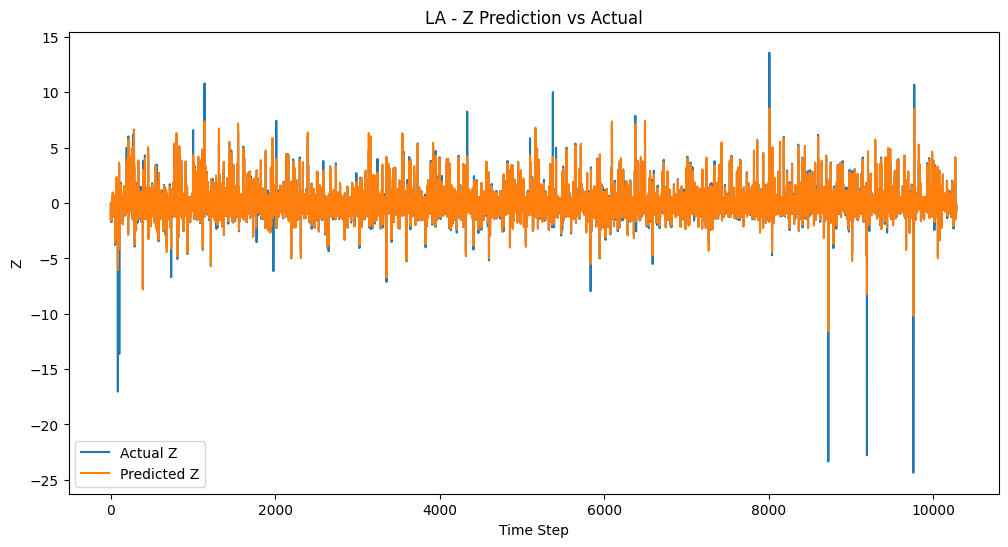


Comparison for LA - R
   Actual R  Predicted R
0 -0.116920    -0.076576
1 -1.442636    -1.492468
2 -0.542919    -0.520062
3 -0.094681    -0.070824
4 -0.010941    -0.061678
5 -0.157680    -0.159947
6 -0.621757    -0.593842
7 -0.138659    -0.122924
8 -1.756553    -1.605861
9 -1.356279    -1.248419


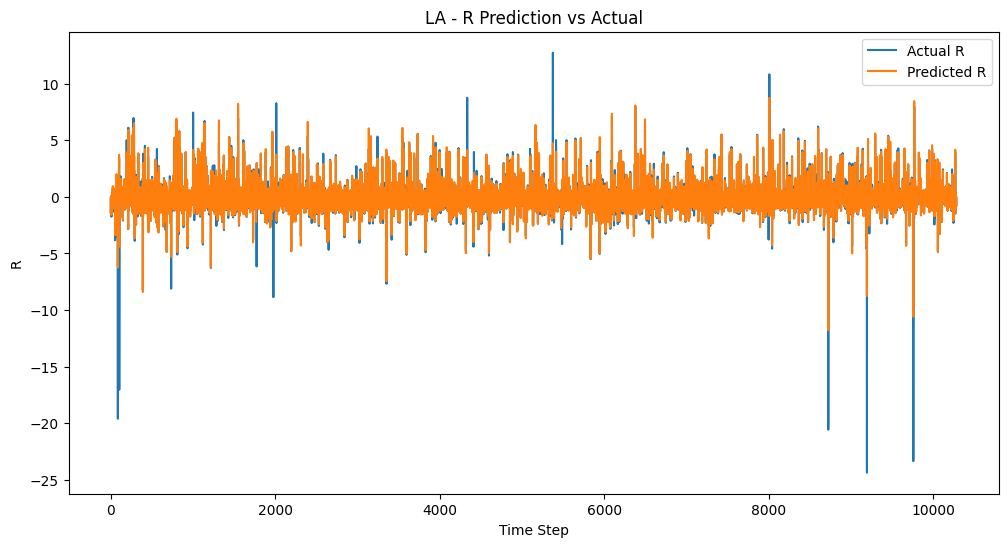


Comparison for LA - Theta
   Actual Theta  Predicted Theta
0     -0.114202        -0.077132
1     -1.453800        -1.492070
2     -0.541560        -0.516805
3     -0.099226        -0.070042
4     -0.008224        -0.071121
5     -0.193006        -0.162152
6     -0.620398        -0.589004
7     -0.141376        -0.129019
8     -1.806146        -1.604675
9     -1.289848        -1.189927


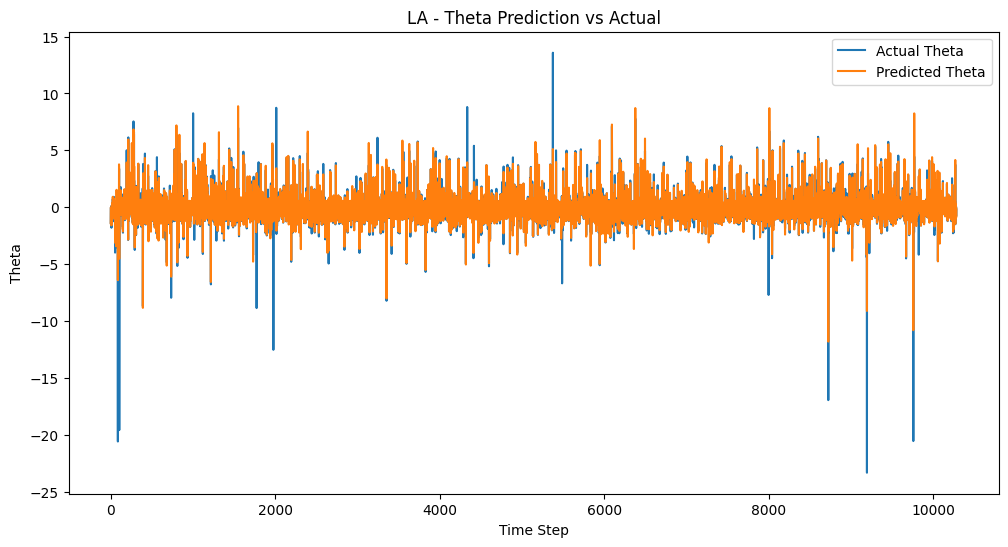

IndexError: index 5 is out of bounds for axis 1 with size 5

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to create, display comparison DataFrame and plot for each joint and each feature
def create_comparison_df_and_plot(joint_index, joint_name):
    actual_values = y_val[:, :, joint_index]
    predicted_values = y_pred[:, :, joint_index]

    features = ['X', 'Y', 'Z', 'R', 'Theta', 'Phi']
    num_features = len(features)

    for i, feature in enumerate(features):
        actual_feature_values = actual_values[:, i]
        predicted_feature_values = predicted_values[:, i]

        # Create DataFrame
        comparison_df = pd.DataFrame(data={
            f'Actual {feature}': actual_feature_values,
            f'Predicted {feature}': predicted_feature_values,
        })

        # Display the first few rows of the comparison DataFrame
        print(f'\nComparison for {joint_name} - {feature}')
        print(comparison_df.head(10))  # Adjust the number of rows to display as needed

        # Optionally, save the comparison to a CSV file
        comparison_df.to_csv(f'/kaggle/working/actual_vs_predicted_comparison_{joint_name}_{feature}.csv', index=False)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(actual_feature_values, label=f'Actual {feature}')
        plt.plot(predicted_feature_values, label=f'Predicted {feature}')
        plt.title(f'{joint_name} - {feature} Prediction vs Actual')
        plt.xlabel('Time Step')
        plt.ylabel(feature)
        plt.legend()
        plt.show()

# Iterate through each joint and create comparison DataFrame and plots for each feature
joint_names = ['LA', 'LH', 'LK', 'RA', 'RH', 'RK']

for i, joint_name in enumerate(joint_names):
    create_comparison_df_and_plot(i, joint_name)
